# Compare cut-based analysis vs ML

In [1]:
import matplotlib.pyplot as plt
import yaml
import numpy as np
import os
import logging

from fastespy.analysis import init_logging
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
init_logging("INFO", color=True)

First select data set, either fits made by Axel or Rikhav

In [123]:
data_set = "Axel"
data_set = "Rikhav"

In [124]:
if data_set == "Axel":
    bkg_id = [2,3,0]
else:
    bkg_id = [0,1,2]

# obs time in seconds from Rikhav's files:
tobs = [78481.169, 68302.174, 202832.210]

In [125]:
indir = "../../../data-04202020/{0:s}-Fits/ml-results/".format(data_set)

In [126]:
idx = bkg_id[0]

In [127]:
with open(os.path.join(indir, "score_results_cuts_{1:s}_bkg_id_{0:n}.yaml".format(idx, data_set))) as f:
    score_cuts = yaml.safe_load(f)

In [128]:
score_cuts['train'].keys()

dict_keys(['F_1', 'F_2', 'F_{1/2}', 'confusion_matrix', 'n_samples', 'precision', 'recall'])

In [129]:
ls $indir

results_ml_Rikhav_bdt_bkg0.npy
results_ml_Rikhav_bdt_bkg1.npy
results_ml_Rikhav_bdt_bkg2.npy
results_ml_Rikhav_dt_bkg0.npy
results_ml_Rikhav_dt_bkg1.npy
results_ml_Rikhav_dt_bkg2.npy
results_ml_Rikhav_rf_bkg0.npy
results_ml_Rikhav_rf_bkg1.npy
results_ml_Rikhav_rf_bkg2.npy
score_results_cuts_Rikhav_bkg_id_0.yaml
score_results_cuts_Rikhav_bkg_id_1.yaml
score_results_cuts_Rikhav_bkg_id_2.yaml


In [130]:
def plot_par_profiles(cl_res, fig=None, cp=plt.cm.tab10):
    """Function to plot parameter scanning for different classifiers and scores"""

    if fig is None:
        fig = plt.figure(figsize=(4*3, 4))
        ax = []

    vmin, vmax = 1., 0.
    for i, score in enumerate(cl_res[classifier]['profile']['mean_test'].keys()):
        for j, par in enumerate(cl_res[classifier]['profile']['mean_test'][score].keys()):
        
            if not i:
                ax.append(plt.subplot(1,len(cl_res[classifier]['profile']['mean_test'][score].keys()), j+1))
        
            if par == 'hidden_layer_sizes':
            
                x = np.unique([np.sum(cl_res[classifier]['gs_cv'][f'param_{par}'].data[i]) for i in \
                               range(cl_res[classifier]['gs_cv'][f'param_{par}'].data.size)])
        
            else:
                x = np.unique(cl_res[classifier]['gs_cv'][f'param_{par}'].data).astype(np.float)
        
            for t in ['test', 'train']:
                ax[j].plot(x, cl_res[classifier]['profile'][f'mean_{t:s}'][score][par],
                           color=cp(i * 0.1), 
                           ls='-' if t == 'test' else '--',
                           label=score + " " + t
                          )
        
                if t == 'test':
                    ax[j].fill_between(x, cl_res[classifier]['profile'][f'mean_{t:s}'][score][par] - \
                                           0.5 * cl_res[classifier]['profile'][f'std_{t:s}'][score][par],
                                       y2=cl_res[classifier]['profile'][f'mean_{t:s}'][score][par] + \
                                           0.5 * cl_res[classifier]['profile'][f'std_{t:s}'][score][par],
                                       color=cp(i * 0.1),
                                       alpha=0.3)
        
            if not i:
                ax[j].set_xlabel(par)

            ax[j].grid()
            
            if j:
                ax[j].tick_params(labelleft=False)
                
            if j == len(list(cl_res[classifier]['profile']['mean_test'][score].keys())) - 1:
                ax[j].legend(bbox_to_anchor=(1.01,1.01),
                             fontsize='small',
                             title=f'{classifier}'
                            )
            v = ax[j].get_ylim()
            if v[0] < vmin:
                vmin = v[0]
            if v[1] > vmax:
                vmax = v[1]
            ax[j].set_ylim(vmin, vmax)
    
    fig.subplots_adjust(wspace=0.05, hspace=0.05, right=0.7)
    return fig, ax    

In [131]:
def plot_learning_curve(cl_res, classifier, score, color='k', fig=None, ax=None):
    """Plot the learning curve for a classifier and score"""
    
    if fig is None:
        fig = plt.figure()
        
    if ax is None:
        ax = fig.add_subplot(111)
    
    train_sizes, train_scores, valid_scores = cl_res[classifier]['learning_curve'][score]
    
    ax.plot(train_sizes, train_scores.mean(axis=1),
             marker='o',
             label=score + " Train",
             ls='--',
             color=color
            )
    ax.fill_between(train_sizes,
                     train_scores.mean(axis=1) - np.sqrt(train_scores.var()),
                     y2=train_scores.mean(axis=1) + np.sqrt(train_scores.var()),
                     alpha=0.3,
                     color=color,
                     zorder=-1
                    )
    
    ax.plot(train_sizes, valid_scores.mean(axis=1),
             marker='o',
             label=score + " valid", ls='-',
             color=color,
            )
    ax.fill_between(train_sizes,
                     valid_scores.mean(axis=1) - np.sqrt(valid_scores.var()),
                     y2=valid_scores.mean(axis=1) + np.sqrt(valid_scores.var()),
                     alpha=0.3,
                     color=color,
                     zorder=-1
                    )

    ax.legend(title=classifier)
    ax.grid()
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Score")

    return fig, ax

In [132]:
cl_res = []
score_cuts = []
for idx in bkg_id:
    
    # load the cuts based analysis results
    with open(os.path.join(indir, "score_results_cuts_{1:s}_bkg_id_{0:n}.yaml".format(idx, data_set))) as f:
        score_cuts.append(yaml.safe_load(f))

        
    # load the ML results
    cl_res.append({})
    for classifier in ['dt', 'bdt', 'rf']:
        
        cl_res[-1][classifier] = np.load(os.path.join(indir, "results_ml_{0:s}_{1:s}_bkg{2:n}.npy".format(data_set, classifier, idx)),
                                         allow_pickle=True
                                         ).flat[0]

### plot the parameter profiles

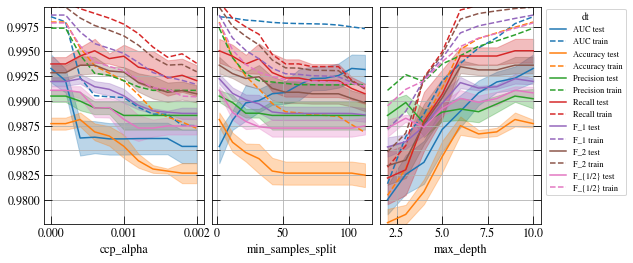

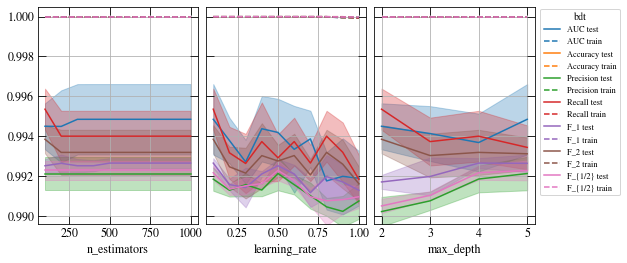

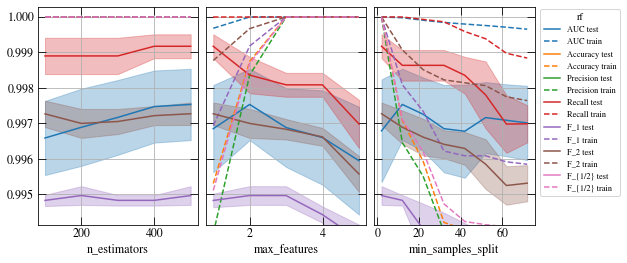

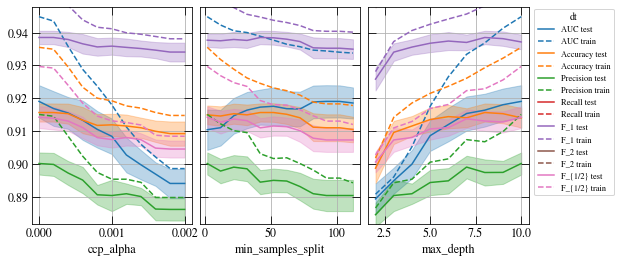

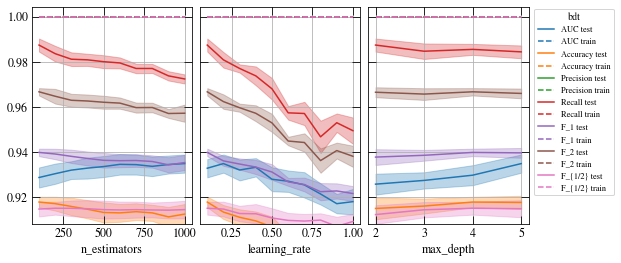

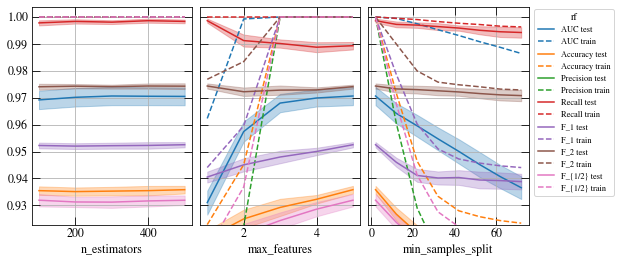

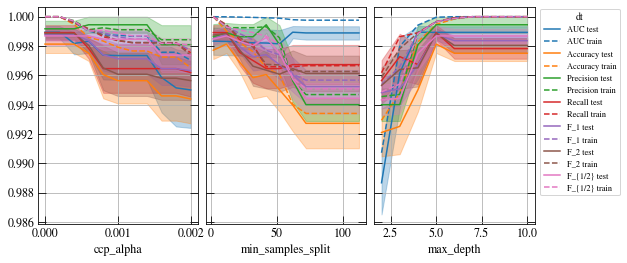

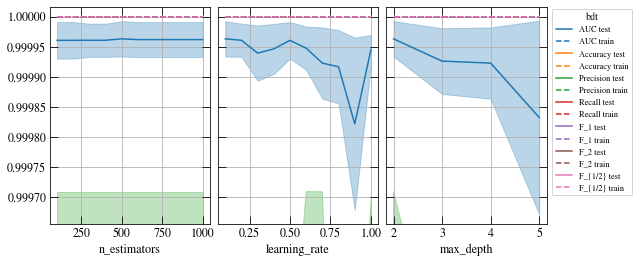

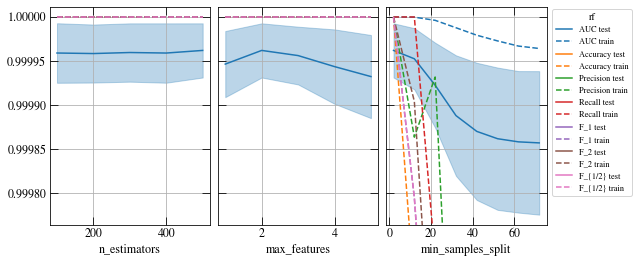

In [133]:
for i, idx in enumerate(bkg_id):
    
    for classifier in ['dt', 'bdt', 'rf']:

        # plot parameter profiles
        fig, ax = plot_par_profiles(cl_res[i])
        
        fig.savefig(f"plots/ml-cuts-comp/par_profile_{classifier}_{data_set}_bkg-id{idx}.png", dpi=150)

### plot the learning curve

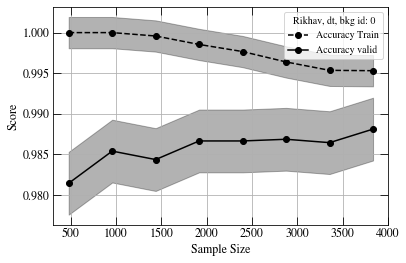

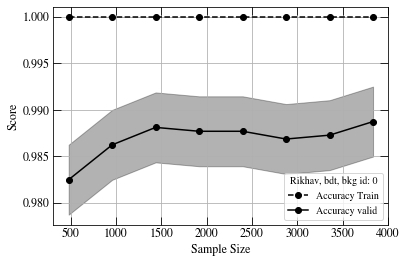

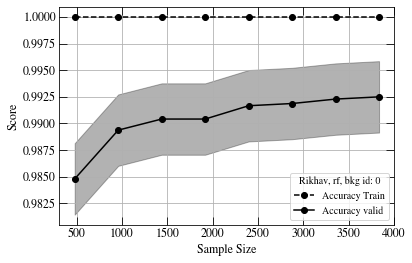

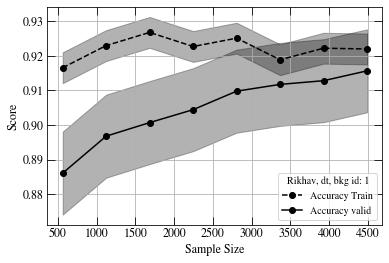

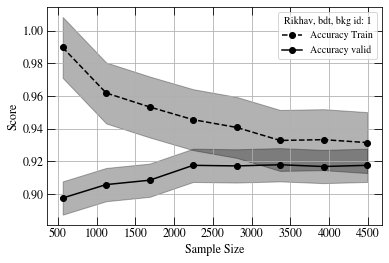

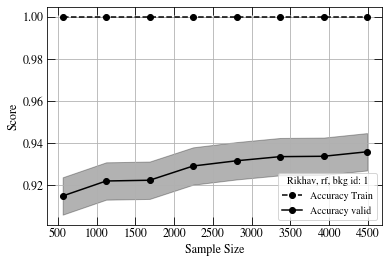

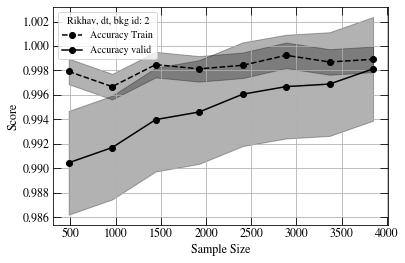

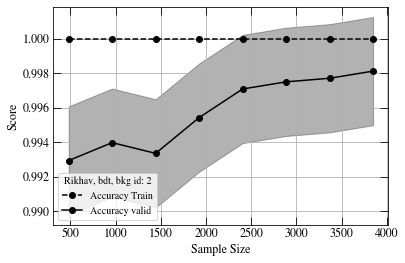

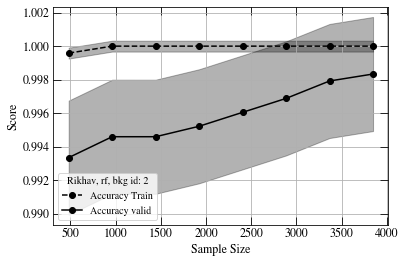

In [134]:
for i, idx in enumerate(bkg_id):
    
    for classifier in ['dt', 'bdt', 'rf']:

        # plot parameter profiles
        for score in cl_res[i][classifier]['learning_curve'].keys():
            
            if not score == 'Accuracy': continue
            
            fig, ax = plot_learning_curve(cl_res[i], classifier=classifier, score=score)
            ax.legend(title=f"{data_set:s}, {classifier:s}, bkg id: {idx:n}")
            
            fig.savefig(f"plots/ml-cuts-comp/learning_curve_{classifier}_{data_set}_{score}_bkg-id{idx}.png", dpi=150)

In [135]:
def plot_comparison_scores(score_cuts, cl_res, cp=plt.cm.tab10, fig=None, ax=None, marker='o'):
    """Plot the comparison of the scores from cut based analysis in ML"""
    
    if fig is None:
        fig = plt.figure()
        
    if ax is None:
        ax = fig.add_subplot(111)
    
    iplot = 0
    
    for i, classifier in enumerate(cl_res.keys()):
        for j, score in enumerate(cl_res[classifier]['score_validation'].keys()):
            
            if not i:
                if score in score_cuts['test'].keys():
                    ax.plot(j, score_cuts['test'][score],
                             marker="*",
                             color=cp(0.1 * (len(list(score_cuts['train'].keys()))-1)),
                             label="Cut based analysis" if not iplot else "",
                             ms=10.,
                             ls="none"
                            )
                    iplot +=1 
                elif score.lower() in score_cuts['test'].keys():
                    ax.plot(j, score_cuts['test'][score.lower()],
                             marker="*",
                             color=cp(0.1 * (len(list(score_cuts['train'].keys()))-1)),
                             ms=10.,
                            ls="none"
                            )
            plt.plot(j, cl_res[classifier]['score_validation'][score],
                     label=classifier if not j else "", 
                     marker=marker,
                     color=cp(0.1 * i),
                     ms=8.,
                     alpha=0.5,
                     ls="none"
                    )

    plt.xticks(list(range(len(cl_res[classifier]['score_validation'].keys()))),
               list(cl_res[classifier]['score_validation'].keys()), 
               rotation=45.
               )

    ax.legend(loc=0, fontsize='small', ncol=2)
    return fig, ax

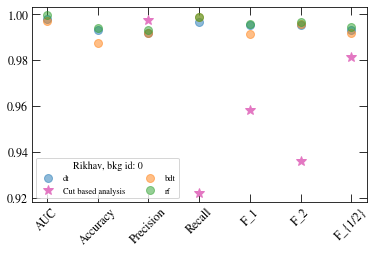

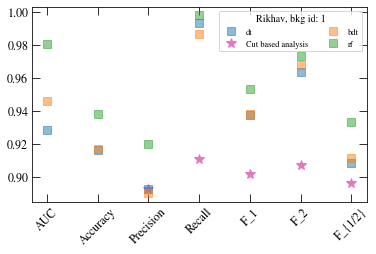

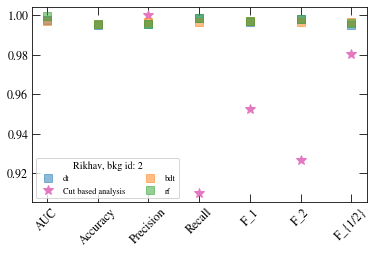

In [136]:
for i, idx in enumerate(bkg_id):
    
    fig, ax = plot_comparison_scores(score_cuts[i], cl_res[i],
                                     marker='o' if not i else 's'
                                    )
    ax.legend(title=f"{data_set:s}, bkg id: {idx:n}",loc=0, fontsize='small', ncol=2)
    fig.subplots_adjust(bottom=0.2)
    fig.savefig(f"plots/ml-cuts-comp/comp_scores_classifiers_{data_set}_bkg-id{idx}.png", dpi=150)

### Plot the confusion matrices

In [137]:
def plot_confusion_matrices(cl_res,
                            score_cuts,
                            score,
                            fig=None,
                            labels=['light', 'bkg 0'],
                            cp=plt.cm.Blues,
                            title="",
                            fname=None
                           ):
    """Plot the confusion matrices for all classifiers"""
    
    if fig is None:
        fig = plt.figure()
    
    len_ax = len(list(cl_res.keys()))
    
    #ax = fig.add_subplot(1, len_ax, 1)
    disp = ConfusionMatrixDisplay(np.array(score_cuts['test']['confusion_matrix']), display_labels=labels)
    disp.plot(cmap=cp, 
              #ax=ax,
              values_format="d")
    plt.title("Cut based analysis" + " " + title)
    
    if fname is not None:
        plt.savefig(fname.format(classifier="cuts", score=""), dpi=150)
    for i, classifier in enumerate(cl_res.keys()):
        
        #ax = fig.add_subplot(1, len_ax, i+2)
        
        disp = ConfusionMatrixDisplay(np.array(cl_res[classifier]['confusion_matrix'][score]), display_labels=labels)
        disp.plot(cmap=cp,
                  #ax=ax,
                  values_format="d")
        plt.title(f"{classifier}" + f" {score} " + title)
        
        if fname is not None:
            plt.savefig(fname.format(classifier=classifier, score=score.replace("{1/2}","0p5")), dpi=150)

<Figure size 432x288 with 0 Axes>

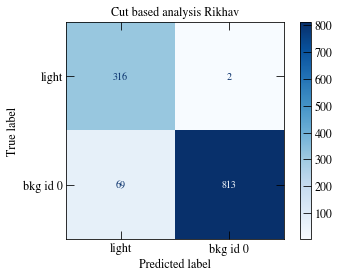

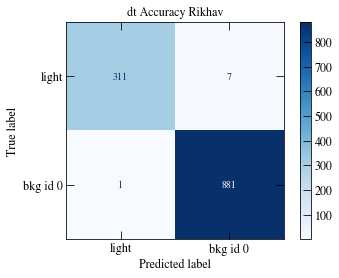

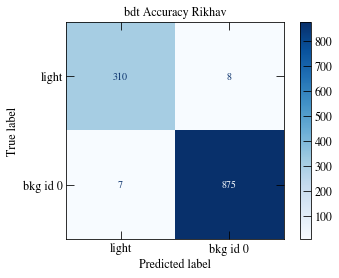

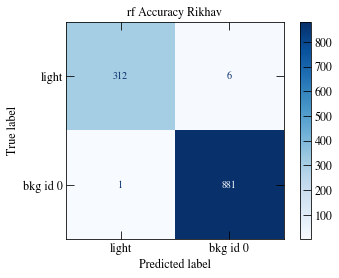

<Figure size 432x288 with 0 Axes>

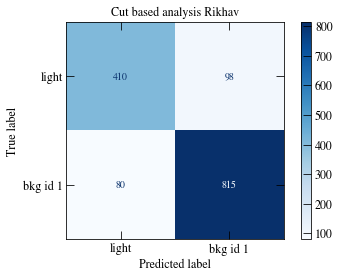

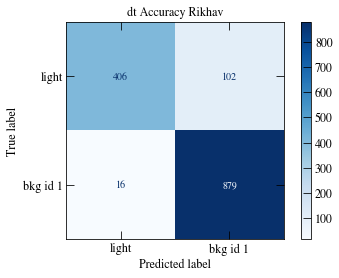

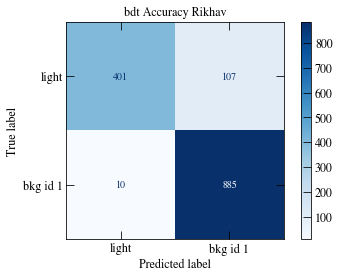

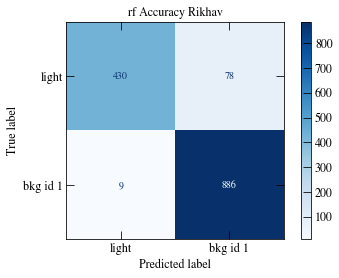

<Figure size 432x288 with 0 Axes>

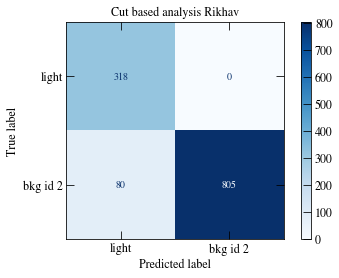

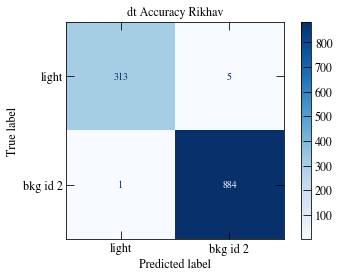

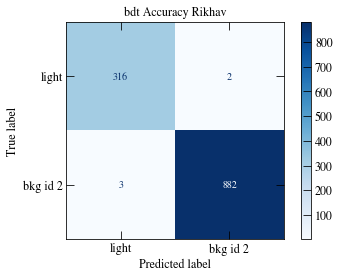

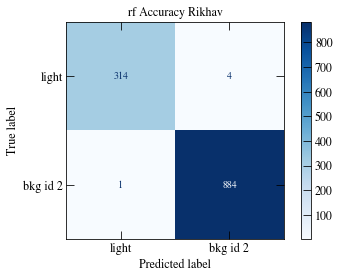

In [138]:

for i, idx in enumerate(bkg_id):

    fname = f"plots/ml-cuts-comp/confusion_matrix_{data_set}_bkg-id{idx}_"
    fname += "{classifier}_{score}.png"
    

    plot_confusion_matrices(cl_res[i], score_cuts[i], score="Accuracy", labels=['light', f'bkg id {idx}'],
                            title=f"{data_set}", fname=fname)

### Plot the background rate:

In [139]:
def plot_bkg_rate(score_cuts, cl_res, tobs, cp=plt.cm.tab10, fig=None, ax=None, marker='o', power_scale=0.):
    """Plot the comparison of the scores from cut based analysis in ML"""
    
    if fig is None:
        fig = plt.figure()
        
    if ax is None:
        ax = fig.add_subplot(111)
    
    # poisson upper limit
    
    if not score_cuts['bkg_pred']:
        bkg_rate = 2.71 / 2. / tobs # 95% U.L.
        yerr = np.array([[bkg_rate / 1. / 10.**power_scale, 0.]]).T
        uplims = True
    else: 
        bkg_rate =  score_cuts['bkg_pred'] / tobs
        yerr = np.sqrt(score_cuts['bkg_pred']) / tobs / 2. / 10.**power_scale
        uplims = False
        
    print ("cuts: {0:.3e} {1}".format(bkg_rate, yerr))
    
    ax.errorbar(len(list(score_cuts['test'].keys())), bkg_rate / 10.**power_scale,
                marker="*",
                color=cp(0.1 * (len(list(score_cuts['train'].keys()))-1)),
                label="Cut based analysis",
                ms=10.,
                ls="none",
                yerr=yerr,
                uplims=uplims
                )
    
    for i, classifier in enumerate(cl_res.keys()):
        for j, score in enumerate(cl_res[classifier]['bkg_pred'].keys()):
            
            # poisson upper limit
            if not cl_res[classifier]['bkg_pred'][score]:
                bkg_rate = 2.71 / 2. / tobs # 95% U.L.
                yerr = np.array([[bkg_rate / 1. / 10.**power_scale, 0.]]).T
                uplims = True
            else: 
                bkg_rate = cl_res[classifier]['bkg_pred'][score] / tobs
                yerr = np.sqrt(cl_res[classifier]['bkg_pred'][score])  / tobs / 2. / 10.**power_scale
                uplims = False
                
            print ("{0:s} {1:s} {2:.3e} {3}".format(classifier, score, bkg_rate, yerr * 10**power_scale))
                
            plt.errorbar(j, bkg_rate / 10.**power_scale,
                         label=classifier if not j else "", 
                         marker=marker,
                         color=cp(0.1 * i),
                         ms=8.,
                         alpha=0.5,
                         ls="none",
                         uplims=uplims,
                         yerr=yerr
                         )
            
    plt.xticks(list(range(len(cl_res[classifier]['score_validation'].keys()))) + [len(list(score_cuts['train'].keys()))],
               list(cl_res[classifier]['score_validation'].keys()) + ['Cuts'], 
               rotation=45.
               )
    
    ax.legend(loc=0, fontsize='small', ncol=2)
    ax.grid(True)
    if not power_scale:
        ax.set_ylabel("Bkg rate")
    else: 
        ax.set_ylabel(r"Bkg rate $(\times10^{{{0:.0f}}})$".format(power_scale))
    return fig, ax

======= 0 =========
cuts: 1.273e-04 0.20140012133829918
dt AUC 6.367e-04 4.503443619891429e-05
dt Accuracy 4.457e-04 3.767851258513076e-05
dt Precision 4.457e-04 3.767851258513076e-05
dt Recall 5.093e-04 4.0280024267659836e-05
dt F_1 4.457e-04 3.767851258513076e-05
dt F_2 5.093e-04 4.0280024267659836e-05
dt F_{1/2} 4.457e-04 3.767851258513076e-05
bdt AUC 4.457e-04 3.767851258513076e-05
bdt Accuracy 5.093e-04 4.0280024267659836e-05
bdt Precision 4.457e-04 3.767851258513076e-05
bdt Recall 8.913e-04 5.3285463507937275e-05
bdt F_1 5.093e-04 4.0280024267659836e-05
bdt F_2 8.913e-04 5.3285463507937275e-05
bdt F_{1/2} 4.457e-04 3.767851258513076e-05
rf AUC 5.093e-04 4.0280024267659836e-05
rf Accuracy 3.820e-04 3.4883524280847094e-05
rf Precision 3.820e-04 3.4883524280847094e-05
rf Recall 6.367e-04 4.503443619891429e-05
rf F_1 3.820e-04 3.4883524280847094e-05
rf F_2 6.367e-04 4.503443619891429e-05
rf F_{1/2} 3.820e-04 3.4883524280847094e-05
======= 1 =========
cuts: 7.172e-03 0.162021108437881

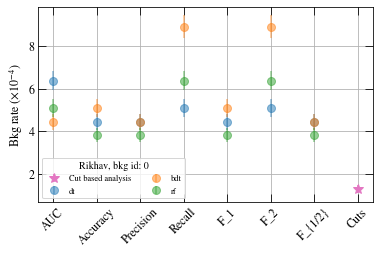

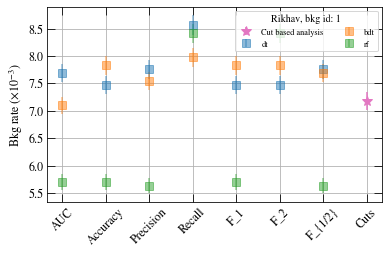

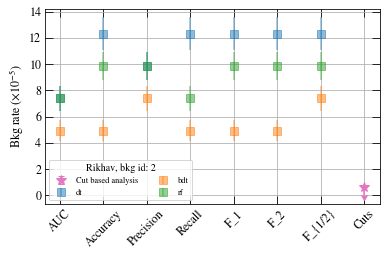

In [140]:
power_scale = [-4,-3,-5]

for i, idx in enumerate(bkg_id):
    
    print (f"======= {idx} =========")
    fig, ax = plot_bkg_rate(score_cuts[i], cl_res[i], tobs[i],
                            marker='o' if not i else 's',
                            power_scale=power_scale[i]
                            )
    ax.legend(title=f"{data_set:s}, bkg id: {idx:n}",loc=0, fontsize='small', ncol=2)
    fig.subplots_adjust(bottom=0.2)
    fig.savefig(f"plots/ml-cuts-comp/bkg_rate_scores_classifiers_{data_set}_bkg-id{idx}.png", dpi=150)

### Plot the confusion matrix for Cut based fits

Plot the confusion matrix for the entire data sests and calculate background rate to have comparison to results obtained by Axel. 

<ipython-input-121-9b7c867fc733>:  11 --- INFO: bkg rate for id 2 on whole data set: 2.2935e-04 Hz from 6077 pulses
<ipython-input-121-9b7c867fc733>:  11 --- INFO: bkg rate for id 3 on whole data set: 7.9060e-03 Hz from 7733 pulses
<ipython-input-121-9b7c867fc733>:  11 --- INFO: bkg rate for id 0 on whole data set: 6.6804e-06 Hz from 6106 pulses


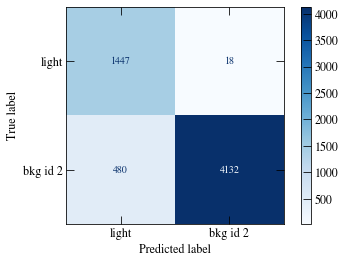

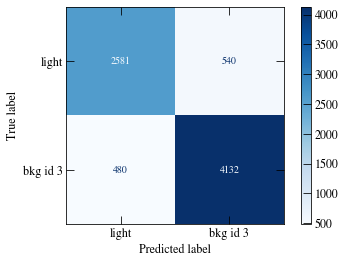

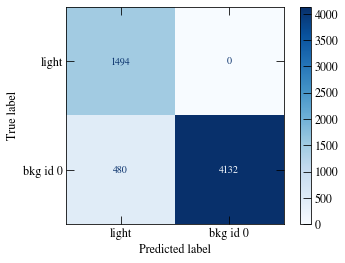

In [121]:
cp =plt.cm.Blues

for i, idx in enumerate(bkg_id):
    cm = np.array(score_cuts[i]['all']['confusion_matrix'])
    disp = ConfusionMatrixDisplay(cm,
                                  display_labels=['light', f'bkg id {idx}'])
    disp.plot(cmap=cp,
              #ax=ax,
              values_format="d")
    npred = cm[0,1] if cm[0,1] else 2.71 / 2.
    logging.info("bkg rate for id {1:d} on whole data set: {0:.4e} Hz from {2:d} pulses".format(npred / tobs[i], idx, cm.sum()))
    
    fname = f"plots/ml-cuts-comp/confusion_matrix_{data_set}_bkg-id{idx}_"
    fname += "_whole_data_set_cuts.png"
    
    plt.savefig(fname, dpi=150)
    